<a href="https://colab.research.google.com/github/thad75/TP_ENSEA_ELEVE/blob/main/3A/SIA/TP2/Generative_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
# !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar xvzf ./maps.tar.gz
# !pip install pytorch-lightning


x maps/
x maps/train/
x maps/train/1.jpg
x maps/train/10.jpg
x maps/train/100.jpg
x maps/train/1000.jpg
x maps/train/1001.jpg
x maps/train/1002.jpg
x maps/train/1003.jpg
x maps/train/1004.jpg
x maps/train/1005.jpg
x maps/train/1006.jpg
x maps/train/1007.jpg
x maps/train/1008.jpg
x maps/train/1009.jpg
x maps/train/101.jpg
x maps/train/1010.jpg
x maps/train/1011.jpg
x maps/train/1012.jpg
x maps/train/1013.jpg
x maps/train/1014.jpg
x maps/train/1015.jpg
x maps/train/530.jpg
x maps/train/531.jpg
x maps/train/532.jpg
x maps/train/533.jpg
x maps/train/534.jpg
x maps/train/535.jpg
x maps/train/536.jpg
x maps/train/537.jpg
x maps/train/538.jpg
x maps/train/539.jpg
x maps/train/54.jpg
x maps/train/540.jpg
x maps/train/541.jpg
x maps/train/542.jpg
x maps/train/543.jpg
x maps/train/544.jpg
x maps/train/545.jpg
x maps/train/546.jpg
x maps/train/547.jpg
x maps/train/548.jpg
x maps/train/549.jpg
x maps/train/55.jpg
x maps/train/550.jpg
x maps/train/551.jpg
x maps/train/552.jpg
x maps/train/553.jpg
x

In [143]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
# from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.autograd import Variable
from pytorch_lightning import loggers as pl_loggers


In [144]:
import torch.nn as nn 
import torch

class ConvDown(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvDown, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.out_channels,
                                            kernel_size = 3,
                                            stride = 1,
                                            padding = 0,
                                            dilation = 1),
                                  nn.BatchNorm2d(self.out_channels),
                                  nn.Dropout2d(0.5),
                                  nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class ConvUp(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvUp, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.model = nn.Sequential(nn.ConvTranspose2d(in_channels = self.in_channels,
                                      out_channels = self.out_channels,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 0,
                                      dilation = 1),
                                      nn.LeakyReLU(0.2))
  def forward(self,x):
      return self.model(x)

class Encoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super(Encoder, self).__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    channels = [in_channels]+ [2**i for i in range(3,10)]
    self.encoder = nn.ModuleList([ConvDown(channels[i], channels[i+1]) for i in range(number_of_stack)])

  def forward(self, x):
    for i, layer in enumerate(self.encoder):
      x = layer(x)
    return x

class Decoder(nn.Module):
  def __init__(self, out_channels,number_of_stack ):
    super(Decoder, self).__init__()
    channels = [out_channels]+ [2**i for i in range(3,10)]
    
    self.decoder = nn.ModuleList([ConvUp(channels[i+1], channels[i]) for i in range(number_of_stack)])[::-1]

  def forward(self, x):
    for i, layer in enumerate(self.decoder):
      x = layer(x)
    return x

############################################## TODO ##############################################
class AutoEncoder(nn.Module):
  def __init__(self, in_channels, number_of_stack):
    super().__init__()
    self.in_channels = in_channels
    self.number_of_stack = number_of_stack
    self.encoder = Encoder(self.in_channels, number_of_stack) 
    self.decoder = Decoder(self.in_channels, number_of_stack)

  def forward(self, x):
    # TODO : Define your forward
    latent_representation = self.encoder(x)
    reconstructed_image = self.decoder(latent_representation)
    return reconstructed_image

# TODO : Create a model composed of 3 stacks
model = AutoEncoder(in_channels=3, number_of_stack=3) # in_channels=3 because input image is RGB, number_of_stack=3 because we want 3 DownConv and 3 UpConv

In [145]:
class AutoEncoderPL(pl.LightningModule):
    def __init__(self, in_channels, number_of_stack):
        super().__init__()
        self.save_hyperparameters()
        # TODO : Define your model here.
        self.in_channels = in_channels
        self.number_of_stack = number_of_stack
        self.model = AutoEncoder(self.in_channels, self.number_of_stack)
        self.loss = nn.MSELoss()

    def forward(self,x):
        # TODO : Send the input through your model
        return self.model(x)

    def configure_optimizers(self):
        # Choose your optimizer 
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3) # 0.001
        return optimizer

    def training_step(self, train_batch, batch_idx):
        # Define your Training Step
        # This method is pretty much similar to what your did in the first lab to train your model.
        x,y = train_batch['satellite'], train_batch['calque']
        x_reconstructed = self.forward(x)
        loss = self.loss(x_reconstructed, x) # it seems appropriate to use the MSELoss for computing the distance between
        # NOT SURE using directly the image of the dataset itself as a label because our goal is to reproduce it

        # Don't remove the next line, you will understand why later
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        # Define your Validation Step
        # What is the difference between the Training and the Validation Step ?
        x,y = val_batch['satellite'], val_batch['calque']
        x_reconstructed = self.forward(x)
        loss = self.loss(x, x_reconstructed) # it seems appropriate to use the MSELoss for computing the distance between 

        self.log('val_loss', loss)
    
    def test_step(self, test_batch, batch_idx):
        # Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        x,y = test_batch['satellite'], test_batch['calque']
        x_reconstructed = self.forward(x)
        loss = self.loss(x_reconstructed, x) 
        # Don't remove the next line, you will understand why later
        self.log('test_loss', loss)

    # TODO : Do we have to add some functions (on_test_epoch_start, on_test_epoch_end..) to compute a reconstruction metric ?
    # let's say no for the moment as I dont know what is the relevant metrics for autoencoders
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch['satellite'], batch['calque']
        return {
                'reconstructed': self.forward(x),
                'base': x
                }

In [146]:

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size = batch_size

    def prepare_data(self):
        # This method is used to download beforehand the dataset if needed.
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
        
    def setup(self, stage):
        # First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            mnist_train_dataset = MNIST(self.data_dir, train=True, transform=self.transform)
            self.train_size = int(0.8 * len(mnist_train_dataset))
            self.valid_size = len(mnist_train_dataset) - self.train_size
            self.mnist_train, self.mnist_valid =  torch.utils.data.random_split(mnist_train_dataset, [self.train_size, self.valid_size]) 
            self.mnist_predict = MNIST(self.data_dir, train=False, transform=self.transform)         
        # Second stage is 'test' 
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_valid, self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.mnist_test,self.batch_size, shuffle=True)
    
    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=True)

In [147]:
class GoogleDataset(Dataset):

  def __init__(self, path, transform = None):
    self.path = path
    self.images = [path + i for i in os.listdir(path)]
    self.transform = transform

  def __getitem__(self,idx):
    image = self.images[idx]
    full_image = cv2.imread(image)
    h, w, c = full_image.shape
    # TODO : Retrieve the correct parts of the image.
    satellite = full_image[:, 0:int(w / 2), :]
    calque = full_image[:, int(w / 2):w, :]
    # debug_plot_separated_img_sample(satellite, calque) # debug to be sure both my pics are well separated
    
    if self.transform : 
      satellite = self.transform(satellite)
      calque = self.transform(calque)
    return {'satellite':calque,
            'calque':satellite}

  def __len__(self):
    return len(self.images)
  


class GoogleMapDataModule(pl.LightningDataModule):

    def __init__(self, batch_size):
        super().__init__()
        # TODO : In your Transformation, transform to Tensor and resize images to 128x128
        self.transform =  transforms.Compose([transforms.ToTensor(),
                                              transforms.Resize((128, 128)),
                                              # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                              ])
        self.batch_size = batch_size

        # we are hardcoding the path are they won't change
        self.train_path = '/Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/centernetImplementation/maps/train/' 
        self.test_path = '/Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/centernetImplementation/maps/val/'

    def prepare_data(self):
        # TODO : load the train and test dataset
        GoogleDataset(self.train_path, self.transform)
        GoogleDataset(self.test_path, self.transform)


    def setup(self, stage):

        #First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            google_train = GoogleDataset(self.train_path, self.transform)
            train_size = int(0.7 * len(google_train ))
            test_size = len(google_train ) - train_size
            self.google_train, self.google_valid =  torch.utils.data.random_split(google_train , [train_size, test_size])
        #Second stage is 'test' 
        if stage == "test" or stage is None:
            self.google_test = GoogleDataset(self.test_path, self.transform)

    def train_dataloader(self):
        # TODO : Now create your Training DataLoader
        return DataLoader(self.google_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        # TODO : Now create your Validation DataLoader
        return DataLoader(self.google_valid, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        # TODO : Now create your Testing DataLoader
        return DataLoader(self.google_test, batch_size=self.batch_size, shuffle=True)
    
    def predict_dataloader(self):
        # TODO : Now create your Testing DataLoader
        return DataLoader(self.google_test, batch_size=self.batch_size, shuffle=False)

In [148]:
# TODO : 
logger = pl_loggers.TensorBoardLogger('diffusionsLogs', name='GAN')
model = AutoEncoderPL(in_channels=3,number_of_stack=3)
dm = GoogleMapDataModule(10)
trainer = pl.Trainer(accelerator="auto",max_epochs=15, logger=logger)
trainer.fit(model, dm)

trainer.test(model, dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name  | Type        | Params
--------------------------------------
0 | model | AutoEncoder | 12.1 K
1 | loss  | MSELoss     | 0     
--------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.049     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 77/77 [00:05<00:00, 13.75it/s, v_num=10]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 77/77 [00:05<00:00, 13.71it/s, v_num=10]


/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 110/110 [00:05<00:00, 21.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0031341295689344406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0031341295689344406}]

In [149]:
%reload_ext tensorboard
%tensorboard --logdir "./diffusionsLogs/GAN/version_8"

Reusing TensorBoard on port 6014 (pid 59998), started 3:57:25 ago. (Use '!kill 59998' to kill it.)

In [150]:
# TODO : Plot some reconstructed images. Are they correct ?
dm.setup('fit')
predict_loader = dm.predict_dataloader()

predictions = trainer.predict(model, predict_loader)

/opt/miniconda3/envs/devIA/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 110/110 [00:05<00:00, 21.55it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


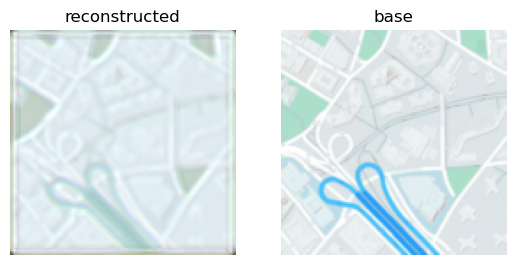

In [151]:
# relunch mutliple times to see differents digits
rand_int313 = np.random.randint(0, 100)
rand_int28 = np.random.randint(0, 9)

base = predictions[rand_int313]['base'][rand_int28]
reconstruction = predictions[rand_int313]['reconstructed'][rand_int28]

reconstruction = np.transpose(reconstruction, (1, 2, 0))
base = np.transpose(base, (1, 2, 0))

fig, axes = plt.subplots(1, 2)  # 1 row, 2 columns

axes[0].imshow(reconstruction, cmap='gray')  # Assuming grayscale image
axes[0].axis('off')
axes[0].set_title('reconstructed')

axes[1].imshow(base, cmap='gray')  # Assuming grayscale image
axes[1].axis('off')
axes[1].set_title('base')

plt.show()